In [1]:
import nltk
nltk.data.path.append("C:/nltk_data")
nltk.download('punkt', download_dir='C:/nltk_data')
nltk.download('stopwords', download_dir='C:/nltk_data')


[nltk_data] Downloading package punkt to C:/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Importing necessary libraries for data manipulation, visualization, and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


In [3]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
import nltk
nltk.download('wordnet')     # For lemmatization
nltk.download('omw-1.4')     # For multilingual WordNet support
nltk.download('averaged_perceptron_tagger')  # For POS tagging (optional)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amira\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amira\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\amira\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\amira\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
df = pd.read_csv('C:\\Users\\amira\\Documents\\Deep-Learning-and-Neural-Networks-project\\IMDB Dataset.csv')

In [13]:
df.head(10)

,review,sentiment,review_length
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230
5,"Probably my all-time favorite movie, a story o...",positive,119
6,I sure would like to see a resurrection of a u...,positive,150
7,"This show was an amazing, fresh & innovative i...",negative,174
8,Encouraged by the positive comments about this...,negative,130
9,If you like original gut wrenching laughter yo...,positive,33


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [7]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

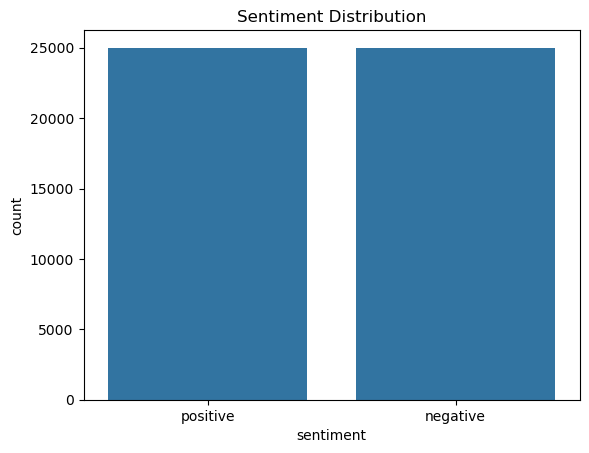

In [8]:
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

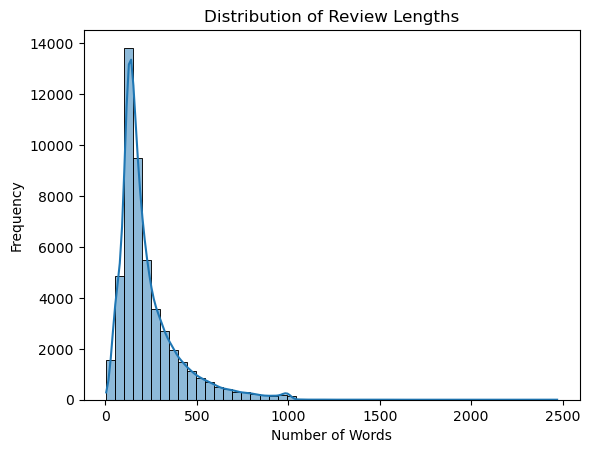

In [9]:
# Step 3: Analyze review lengths (for insight only)
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [10]:
# Step 4: Preprocess text - Lowercase, remove HTML, URLs, tokenize, remove stopwords
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    tokens = word_tokenize(text)  # Tokenize text
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(filtered_tokens)  # Join tokens back to a string

In [11]:
import nltk

nltk.download('punkt')                             # Tokenizer
nltk.download('stopwords')                         # Stopwords
nltk.download('wordnet')                           # Lemmatizer
nltk.download('omw-1.4')                           # WordNet lemmatizer support
nltk.download('averaged_perceptron_tagger')        # POS tagger


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amira\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amira\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\amira\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\amira\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
# Apply preprocessing to the reviews
df['clean_review'] = df['review'].apply(preprocess_text)

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\amira/nltk_data'
    - 'd:\\anaconda\\nltk_data'
    - 'd:\\anaconda\\share\\nltk_data'
    - 'd:\\anaconda\\lib\\nltk_data'
    - 'C:\\Users\\amira\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - 'C:/nltk_data'
**********************************************************************


In [ ]:
# Step 5: Convert text data to numerical format using TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)  # Limit features for speed and performance
X = vectorizer.fit_transform(df['clean_review']).toarray()  # Convert sparse matrix to dense

In [ ]:
# Step 6: Encode the target labels (positive -> 1, negative -> 0)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiment'])

In [ ]:
# Step 7: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Step 8: Build the Neural Network model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X.shape[1]))  # Input layer
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

In [ ]:
# Step 8: Build the Neural Network model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X.shape[1]))  # Input layer
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Step 9: Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Step 10: Train the model and store training history
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.2)

# Step 11: Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}')

# Step 12: Visualize training & validation loss and accuracy over epochs
plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Step 13: Final Thoughts (printed as part of the script)
print("\n\033[1mReport Summary:\033[0m")
print("- The model was able to learn and classify movie reviews with decent accuracy.")
print("- Preprocessing text (cleaning, tokenizing, removing stopwords) was key to improving input quality.")
print("- Using TF-IDF limited to 5000 features helped balance between information and performance.")
print("- Future improvements could include:")
print("   - Using LSTM/RNNs for sequential understanding.")
print("   - Fine-tuning hyperparameters or adding dropout layers.")
print("   - Exploring pretrained language models like BERT for transfer learning.")